# 시스템 손절매의 실례: 수익곡선 모멘텀 그림 2-38
- 투자 기간 :1986년 7월~2017년 6월
- 투자자산 : 코스피지수 월봉
- 투자 전략 : 12개월 평균 모멘텀 스코어 전략(연 3% 수익 가정 현금 혼합 전략) + 6개월 평균 모멘텀 스코어 시스템 손절매 전략
    - 12개월 평균 모멘텀 스코어 전략(현금 혼합)으로 전략이 마무리 되는 것이 아니라, 이 수익곡선 자체의 모멘텀 스코어를 매달 평가하여 기본 전략의 투자 비중을 매달 조절하는 전략입니다. 
    - 예를 들어 이번 달의 수익곡선 모멘텀 스코어가 0.75이었다면, 투자 비중은 평균 모멘텀 스코어 전략 75%, 현금 25%가 됩니다. 이중 75%만 전략에 투자합니다.
- 결과
    - 코스피 : 7.2%/-73.1%
    - 평균 모멘텀 스코어 현금 혼합 전략 : 6.4%/-19.1%
    - 수익곡선 모멘텀 전략 : 6.4%/-10.2%
    - 일종의 **시장 적응 전략(Market Adaptive Strategy)**

In [1]:
from settings import *

In [2]:
kospi = fdr.DataReader("KS11")['Close']
kospi

Date
1981-05-01    123.600
1981-05-02    123.500
1981-05-04    120.600
1981-05-06    120.700
1981-05-07    119.300
               ...   
2022-02-08   2746.470
2022-02-09   2768.850
2022-02-10   2771.930
2022-02-11   2747.710
2022-02-14   2711.310
Name: Close, Length: 10888, dtype: float64

## 월별 비중 데이터프레임 (WeighTarget) : 월말 리밸런싱, 월말 비중 계산, 월말 데이터

월말리밸런싱을 가정하기 위해 월말로 된 데이터를 구성한다.

In [3]:
df = pd.DataFrame()
df['KOSPI'] = kospi.copy()
month_last = df.groupby(df.index.to_period('M')).apply(lambda x: x.index.max())
month_df = df.loc[month_last].copy()
# df = df['1985-1':'2017-6'].resample('MS').first() # 실제 말 마지막날이 공휴일이어도 마지막날 거래 한것과 같이 된다.
month_df['현금'] = pow(1.03, 1/12)
month_df['현금'] = month_df['현금'].shift(1, fill_value=1.0)
month_df['현금'] = month_df['현금'].cumprod()
month_df

,KOSPI,현금
Date,,
1981-05-30,126.300,1.000
1981-06-30,150.800,1.002
1981-07-31,148.100,1.005
1981-08-31,140.100,1.007
1981-09-30,132.300,1.010
...,...,...
2021-10-29,2970.680,3.302
2021-11-30,2839.010,3.311
2021-12-30,2977.650,3.319


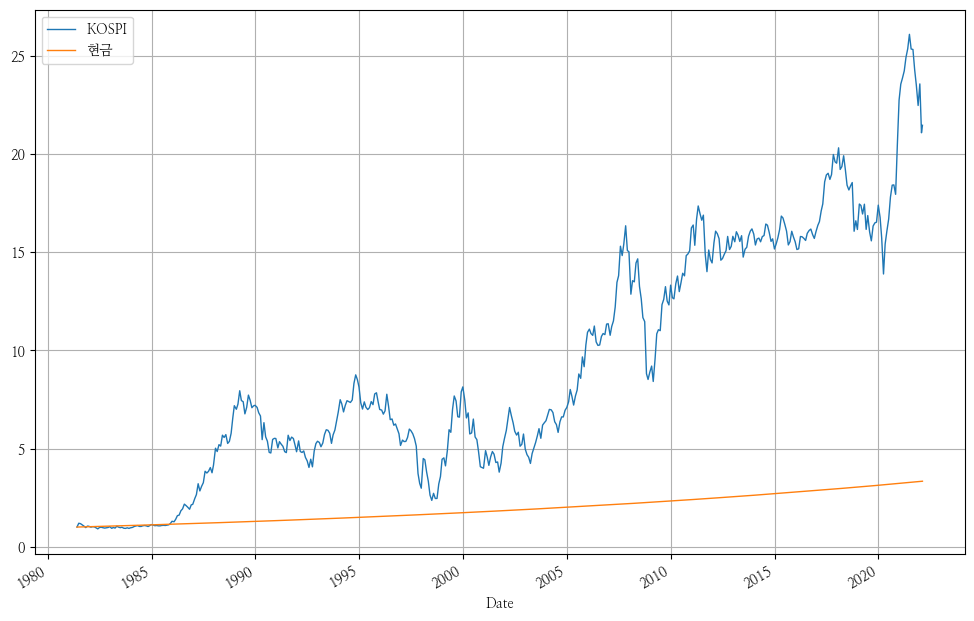

In [4]:
month_df.rebase(1).plot(figsize=(12,8));

In [5]:
data = month_df.copy()
data

,KOSPI,현금
Date,,
1981-05-30,126.300,1.000
1981-06-30,150.800,1.002
1981-07-31,148.100,1.005
1981-08-31,140.100,1.007
1981-09-30,132.300,1.010
...,...,...
2021-10-29,2970.680,3.302
2021-11-30,2839.010,3.311
2021-12-30,2977.650,3.319


In [6]:
s = '1985-1-30'
e = '2017-6-30'

In [7]:
bt_ew = long_only_ew(data, ['KOSPI', '현금'], "ew")

## 평균모멘텀스코어 비중 데이터프레임

In [8]:
score = 평균모멘텀스코어(data) # 월말데이터

In [9]:
# KOSPI만 평균모멘텀스코어 비중 만큼 투자하고 나머지는 현금
weights0 = pd.DataFrame()
weights0['KOSPI'] = score['KOSPI']
weights0['현금']  = 1.0 - score['KOSPI']
weights0.head(20) # 1986-1 이후 유효

,KOSPI,현금
Date,,
1981-05-30,NaN,NaN
1981-06-30,NaN,NaN
1981-07-31,NaN,NaN
1981-08-31,NaN,NaN
1981-09-30,NaN,NaN
1981-10-31,NaN,NaN
1981-11-30,NaN,NaN
1981-12-24,NaN,NaN
1982-01-30,NaN,NaN


In [10]:
# 현금도 하나의 자산으로 취급. 이론 현금은 항상 모멘텀스코어가 1이다.
# 따라서 주식 비중이 0.5를 넘을 수 없다.
weights_현금혼합 = score.copy()
weights_현금혼합 = weights_현금혼합.div(weights_현금혼합.sum(axis=1), axis=0) # !!
weights_현금혼합.head(20)

,KOSPI,현금
Date,,
1981-05-30,NaN,NaN
1981-06-30,NaN,NaN
1981-07-31,NaN,NaN
1981-08-31,NaN,NaN
1981-09-30,NaN,NaN
1981-10-31,NaN,NaN
1981-11-30,NaN,NaN
1981-12-24,NaN,NaN
1982-01-30,NaN,NaN


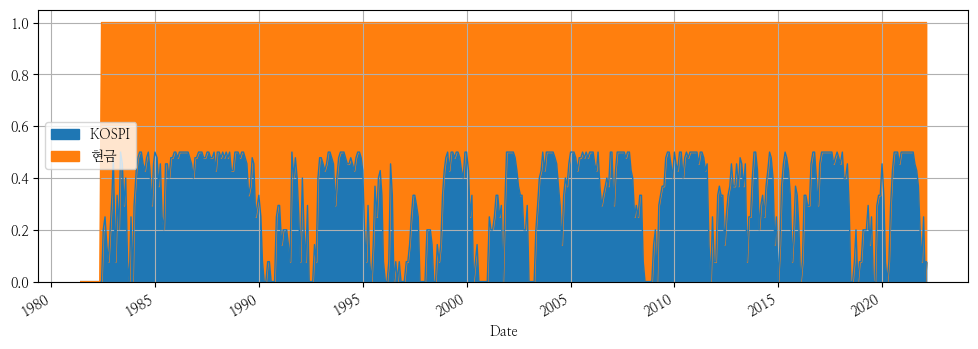

In [11]:
weights_현금혼합.plot.area(figsize=(12,4));

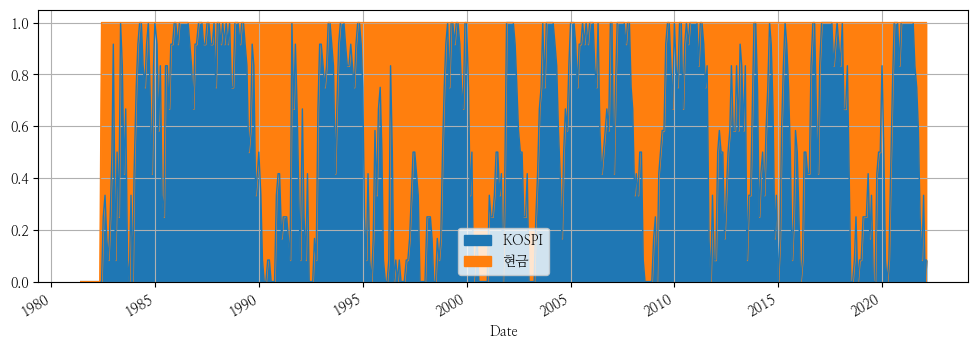

In [12]:
weights0.plot.area(figsize=(12,4));

In [13]:
def momentumscore(data, weights, name="MomScore", start='1986-1-03'):
    st = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_end_of_period=True,run_on_last_date=True), # 월말
            bt.algos.RunAfterDate(start), #1년 뒤부터 시작 : 시작전 12개월 데이터 필요
            bt.algos.SelectAll(),
            bt.algos.WeighTarget(weights),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000.0)

In [119]:
# shift(1)을 하면 전달 기준으로 모멘텀 계산
bt_ms0 = momentumscore(data, weights0, name='모멘텀 포트폴리오(KOSPI)_월데이터')#.shift(1))
bt_ms_현금혼합 = momentumscore(data, weights_현금혼합, name='모멘텀 포트폴리오(현금혼합)_월데이터')#.shift(1))

In [120]:
bt_kospi = long_only_ew(data, ['KOSPI'], 'KOSPI')
bt_현금 = long_only_ew(data, ['현금'], '현금')

In [121]:
r_ms_현금혼합 = bt.run(bt_ms_현금혼합)

1986-01-31 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.478 현금:0.522 
1986-02-28 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1986-03-31 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1986-04-30 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1986-05-31 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1986-06-30 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1986-07-31 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1986-08-30 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.478 현금:0.522 
1986-09-30 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.455 현금:0.545 
1986-10-31 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.400 현금:0.600 
1986-11-29 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.478 현금:0.522 
1986-12-26 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.478 현금:0.522 
1987-01-31 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1987-02-28 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1987-03-31 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.500 현금:0.500 
1987-04-30 00:00:00 모멘텀 포트폴리오(현금혼합)_월데이터 KOSPI:0.478 현금

In [122]:
start평균모멘텀스코어 = '1986-1-31' # 최초 매수일
# %%
start수익곡선모멘텀 = '1986-7-31'

In [123]:
r_ms_현금혼합.set_date_range(start수익곡선모멘텀, e)
r_ms_현금혼합.display()

Stat                 모멘텀 포트폴리오(현금혼합)_월데이터
-------------------  --------------------------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         587.25%
Daily Sharpe         -
Daily Sortino        -
CAGR                 6.43%
Max Drawdown         -19.12%
Calmar Ratio         0.34

MTD                  1.07%
3m                   7.53%
6m                   9.43%
YTD                  9.43%
1Y                   11.05%
3Y (ann.)            3.96%
5Y (ann.)            2.93%
10Y (ann.)           3.13%
Since Incep. (ann.)  6.43%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    -
Daily Vol (ann.)     -
Daily Skew           -
Daily Kurt           -
Best Day             -
Worst Day            -

Monthly Sharpe       0.74
Monthly Sortino      1.63
Monthly Mean (ann.)  6.64%
Monthly Vol (ann.)   8.97%
Monthly Skew         0.95
Monthly Kurt         2.57
Best Month           10.92%
Worst Month          -5.62%

Yea

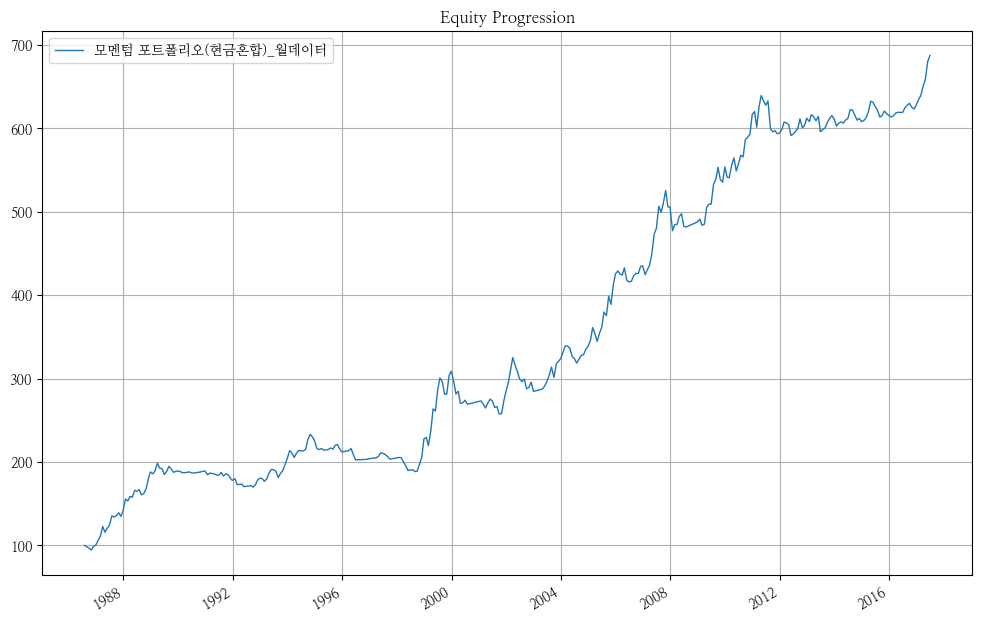

In [124]:
r_ms_현금혼합.plot(figsize=(12,8));

In [125]:
r_all = bt.run(bt_ms_현금혼합, bt_ms0, bt_kospi, bt_ew)

1986-01-31 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:0.917 현금:0.083 
1986-02-28 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1986-03-31 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1986-04-30 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1986-05-31 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1986-06-30 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1986-07-31 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1986-08-30 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:0.917 현금:0.083 
1986-09-30 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:0.833 현금:0.167 
1986-10-31 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:0.667 현금:0.333 
1986-11-29 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:0.917 현금:0.083 
1986-12-26 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:0.917 현금:0.083 
1987-01-31 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1987-02-28 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1987-03-31 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이터 KOSPI:1.000 현금:0.000 
1987-04-30 00:00:00 모멘텀 포트폴리오(KOSPI)_월데이

In [126]:
r_all.set_date_range(start수익곡선모멘텀, e)
r_all.stats

,모멘텀 포트폴리오(현금혼합)_월데이터,모멘텀 포트폴리오(KOSPI)_월데이터,KOSPI,ew
start,1986-07-31 00:00:00,1986-07-31 00:00:00,1986-07-31 00:00:00,1986-07-31 00:00:00
end,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00
rf,0.000,0.000,0.000,0.000
total_return,5.872,14.127,7.737,5.555
cagr,0.064,0.092,0.073,0.063
max_drawdown,-0.191,-0.331,-0.731,-0.608
calmar,0.336,0.278,0.099,0.103
mtd,0.011,0.019,0.019,0.017
three_month,0.075,0.143,0.143,0.124
six_month,0.094,0.177,0.180,0.155


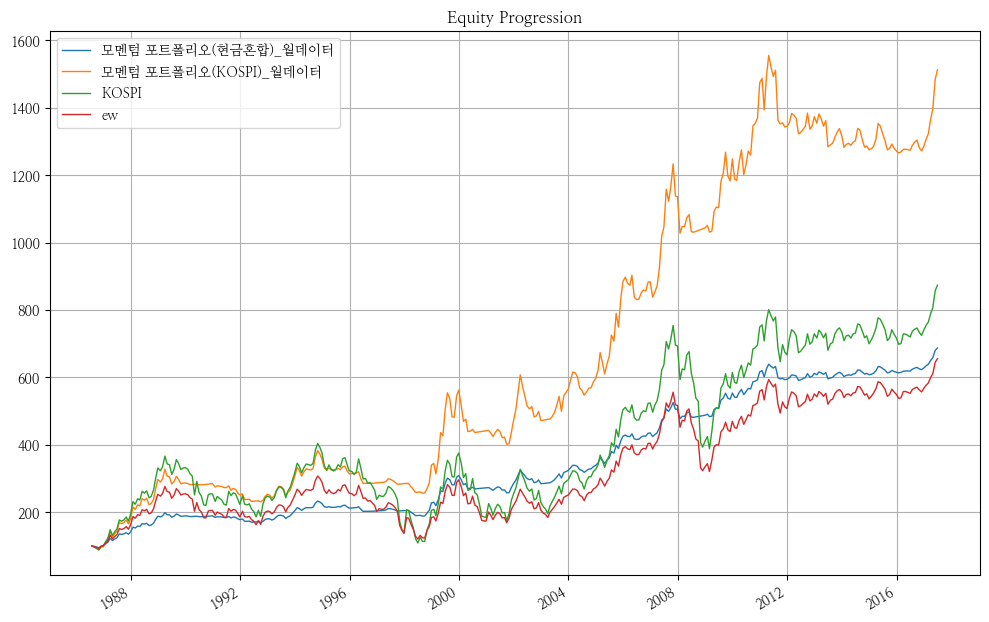

In [127]:
r_all.plot(figsize=(12,8));

In [128]:
r_현금 = bt.run(bt_현금)
r_kospi = bt.run(bt_kospi)
r_ms0 = bt.run(bt_ms0)

1981-05-30 00:00:00


### 그림 2.26

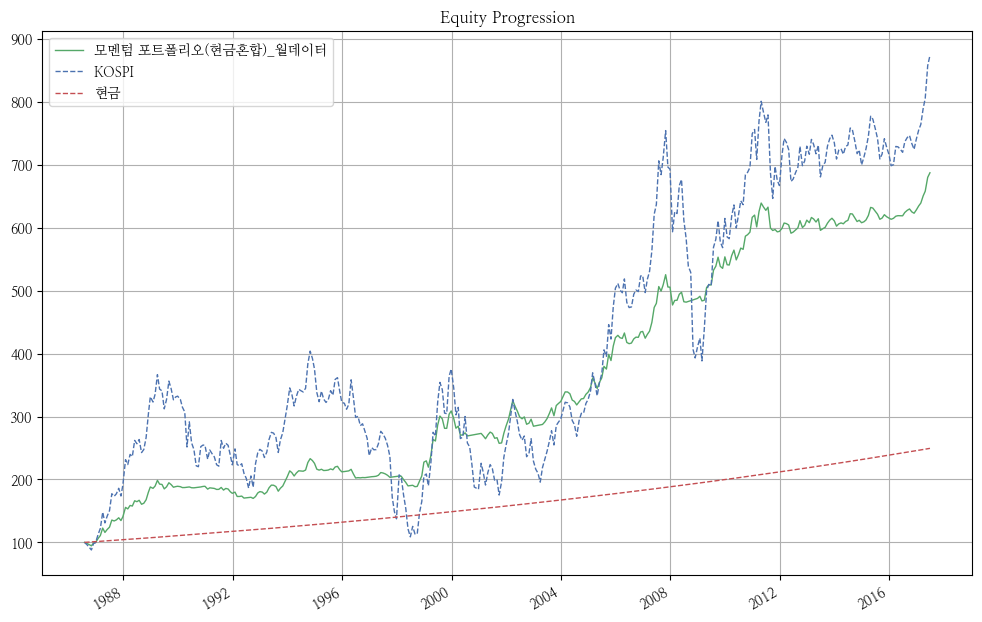

In [129]:
r_ms_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_kospi.set_date_range(start수익곡선모멘텀,e)
r_현금.set_date_range(start수익곡선모멘텀,e)
ax1 = r_ms_현금혼합.plot(color='g', figsize=(12,8));
r_kospi.plot(ax=ax1, ls='--', color='b', figsize=(12, 8));
r_현금.plot(ax=ax1, ls='--', color='r', figsize=(12, 8));
#----
# r_ms0.plot(ax=ax1, ls='--', color='gray', figsize=(12, 8));

## 수익곡선모멘텀(평균모멘텀스코어 6개월)

In [130]:
r_ms_현금혼합.set_date_range(start평균모멘텀스코어)
r_ms_현금혼합.prices

,모멘텀 포트폴리오(현금혼합)_월데이터
1986-01-31,100.000
1986-02-28,104.747
1986-03-31,111.977
1986-04-30,112.998
1986-05-31,120.975
...,...
2021-10-29,1097.805
2021-11-30,1090.239
2021-12-30,1096.817
2022-01-28,1069.902


### 데이타 생성 
- 현금혼합 전략의 결과로 부터

In [131]:
data_현금혼합 = pd.DataFrame()
data_현금혼합['평균모멘텀스코어현금혼합전략'] = r_ms_현금혼합.prices.rebase(1).copy() # rebase()로 현금과 맞춰준다. 디버깅을 쉽게하기 위해
data_현금혼합['현금'] = pow(1.03, 1/12)
data_현금혼합['현금'] = data_현금혼합['현금'].shift(1, fill_value=1.0)
data_현금혼합['현금'] = data_현금혼합['현금'].cumprod()
data_현금혼합

,평균모멘텀스코어현금혼합전략,현금
1986-01-31,1.000,1.000
1986-02-28,1.047,1.002
1986-03-31,1.120,1.005
1986-04-30,1.130,1.007
1986-05-31,1.210,1.010
...,...,...
2021-10-29,10.978,2.877
2021-11-30,10.902,2.884
2021-12-30,10.968,2.891
2022-01-28,10.699,2.898


In [132]:
score_수익곡선모멘텀 = 평균모멘텀스코어6(data_현금혼합)
score_수익곡선모멘텀.head(10)

,평균모멘텀스코어현금혼합전략,현금
1986-01-31,NaN,NaN
1986-02-28,NaN,NaN
1986-03-31,NaN,NaN
1986-04-30,NaN,NaN
1986-05-31,NaN,NaN
1986-06-30,NaN,NaN
1986-07-31,1.000,1.000
1986-08-30,0.833,1.000
1986-09-30,0.667,1.000
1986-10-31,0.500,1.000


In [133]:
weights_수익곡선모멘텀 = score_수익곡선모멘텀.copy()

weights_수익곡선모멘텀['평균모멘텀스코어현금혼합전략'] = score_수익곡선모멘텀['평균모멘텀스코어현금혼합전략']
weights_수익곡선모멘텀['현금']  = 1.0 - score_수익곡선모멘텀['평균모멘텀스코어현금혼합전략']

weights_수익곡선모멘텀.dropna().head(10)

,평균모멘텀스코어현금혼합전략,현금
1986-07-31,1.000,0.000
1986-08-30,0.833,0.167
1986-09-30,0.667,0.333
1986-10-31,0.500,0.500
1986-11-29,0.833,0.167
1986-12-26,0.833,0.167
1987-01-31,1.000,0.000
1987-02-28,1.000,0.000
1987-03-31,1.000,0.000
1987-04-30,0.833,0.167


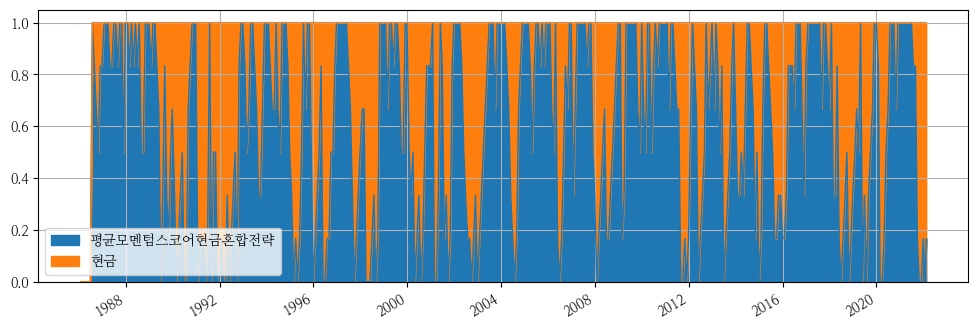

In [134]:
weights_수익곡선모멘텀.plot.area(figsize=(12,4));

In [135]:
bt_ms_수익곡선모멘텀 = momentumscore(data_현금혼합, weights_수익곡선모멘텀, name='수익곡선모멘텀전략_월데이터')#.shift(1))

In [136]:
r_ms_수익곡선모멘텀 = bt.run(bt_ms_수익곡선모멘텀)

1986-01-31 00:00:00 수익곡선모멘텀전략_월데이터 
1986-02-28 00:00:00 수익곡선모멘텀전략_월데이터 
1986-03-31 00:00:00 수익곡선모멘텀전략_월데이터 
1986-04-30 00:00:00 수익곡선모멘텀전략_월데이터 
1986-05-31 00:00:00 수익곡선모멘텀전략_월데이터 
1986-06-30 00:00:00 수익곡선모멘텀전략_월데이터 
1986-07-31 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:1.000 현금:0.000 
1986-08-30 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:0.833 현금:0.167 
1986-09-30 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:0.667 현금:0.333 
1986-10-31 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:0.500 현금:0.500 
1986-11-29 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:0.833 현금:0.167 
1986-12-26 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:0.833 현금:0.167 
1987-01-31 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:1.000 현금:0.000 
1987-02-28 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:1.000 현금:0.000 
1987-03-31 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:1.000 현금:0.000 
1987-04-30 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:0.833 현금:0.167 
1987-05-30 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:0.833 현금:0.167 
1987-06-30 00:00:00 수익곡선모멘텀전략_월데이터 평균모멘텀스코어현금혼합전략:1.000 현금

In [137]:
r_ms_수익곡선모멘텀.set_date_range(start수익곡선모멘텀, e)
r_ms_수익곡선모멘텀.display()

Stat                 수익곡선모멘텀전략_월데이터
-------------------  -----------------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         589.11%
Daily Sharpe         -
Daily Sortino        -
CAGR                 6.44%
Max Drawdown         -10.19%
Calmar Ratio         0.63

MTD                  1.07%
3m                   7.53%
6m                   9.29%
YTD                  9.29%
1Y                   10.48%
3Y (ann.)            4.64%
5Y (ann.)            2.89%
10Y (ann.)           2.97%
Since Incep. (ann.)  6.44%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    -
Daily Vol (ann.)     -
Daily Skew           -
Daily Kurt           -
Best Day             -
Worst Day            -

Monthly Sharpe       0.87
Monthly Sortino      2.09
Monthly Mean (ann.)  6.54%
Monthly Vol (ann.)   7.54%
Monthly Skew         1.51
Monthly Kurt         5.32
Best Month           10.92%
Worst Month          -5.62%

Yearly Sharpe     

In [138]:
r_all = bt.run(bt_ms_수익곡선모멘텀, bt_ms_현금혼합, bt_ms0, bt_kospi, bt_ew)

In [139]:
r_all.set_date_range(start수익곡선모멘텀,e)
r_all.stats

,수익곡선모멘텀전략_월데이터,모멘텀 포트폴리오(현금혼합)_월데이터,모멘텀 포트폴리오(KOSPI)_월데이터,KOSPI,ew
start,1986-07-31 00:00:00,1986-07-31 00:00:00,1986-07-31 00:00:00,1986-07-31 00:00:00,1986-07-31 00:00:00
end,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00
rf,0.000,0.000,0.000,0.000,0.000
total_return,5.891,5.872,14.127,7.737,5.555
cagr,0.064,0.064,0.092,0.073,0.063
max_drawdown,-0.102,-0.191,-0.331,-0.731,-0.608
calmar,0.632,0.336,0.278,0.099,0.103
mtd,0.011,0.011,0.019,0.019,0.017
three_month,0.075,0.075,0.143,0.143,0.124
six_month,0.093,0.094,0.177,0.180,0.155


### 그림 2.38

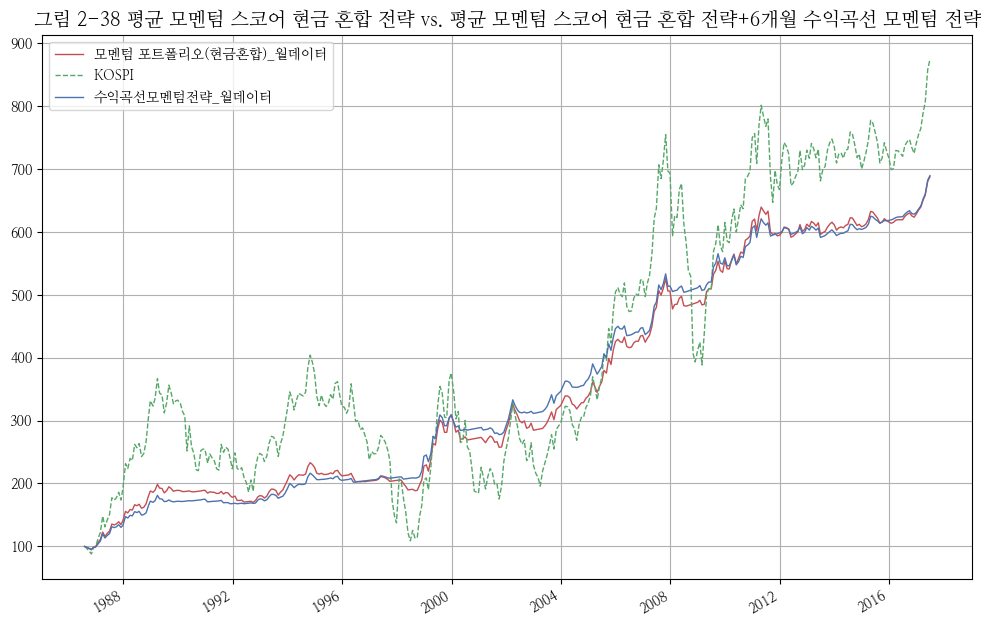

In [140]:
r_ms_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_kospi.set_date_range(start수익곡선모멘텀,e)
r_ms_수익곡선모멘텀.set_date_range(start수익곡선모멘텀,e)
ax1 = r_ms_현금혼합.plot(color='r', figsize=(12,8));
r_kospi.plot(ax=ax1, ls='--', color='g', figsize=(12, 8));
r_ms_수익곡선모멘텀.plot(ax=ax1, ls='-', color='b', figsize=(12, 8));
#----
# r_ms0.plot(ax=ax1, ls='--', color='gray', figsize=(12, 8));
plt.title("그림 2-38 평균 모멘텀 스코어 현금 혼합 전략 vs. 평균 모멘텀 스코어 현금 혼합 전략+6개월 수익곡선 모멘텀 전략", fontsize=14);

# 일일데이터 비중 클래스 구현 
- 일간->월간 변경 후 모멘텀스코어 구하는 법

In [141]:
s, e, start평균모멘텀스코어, start수익곡선모멘텀

('1985-1-30', '2017-6-30', '1986-1-31', '1986-7-31')

## 데이타 생성

In [142]:
# kospi = fdr.DataReader("KS11")['Close']
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily[s:e]
# %%
dd = pd.DataFrame()
# dd.index = pd.date_range('1985', '2020-9-30', freq='D')
dd.index = pd.date_range(s, e, freq='D')
denominator = len(pd.date_range(s, e, freq='D'))/len(pd.date_range(s, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')

In [143]:
data_daily

,KOSPI,현금
Date,,
1985-01-30,137.970,1.000
1985-01-31,138.900,1.000
1985-02-01,138.840,1.000
1985-02-02,138.480,1.000
1985-02-04,136.870,1.000
...,...,...
2017-06-26,2388.660,2.574
2017-06-27,2391.950,2.574
2017-06-28,2382.560,2.574


월초 거래, 이전달 종가로 계산

In [144]:
data_daily['1986-8'].head()

,KOSPI,현금
Date,,
1986-08-01,267.560,1.045
1986-08-02,271.350,1.045
1986-08-04,270.890,1.045
1986-08-05,268.400,1.045
1986-08-06,262.510,1.045


## 평균모멘텀스코어 WeighAMSWithCash

In [40]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMSWithCash(bt.Algo):
    def __init__(self, lags, months, cash):
        super(WeighAMSWithCash, self).__init__()
        self.lags = lags
        self.months = months
        self.cash = cash

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lags)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lags) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        print(f"\nprc : {target.now} {t0} ~ {start}")
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False

        # weights = pd.Series(self.평균모멘텀스코어(prc, self.months), index=selected)
        weights = pd.Series(self.AMS(prc), index=selected)
        weights = weights/weights.sum()
        
        # print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights

        return True

In [41]:
class WeighAverageMomentumScoreIncludeCash(bt.Algo):
    """ 자산에 현금을 포함한 평균모멘텀스코어 전략
    
    매월초에 리밸런싱하고 전달 종가 기준으로 lookback 만큼의 월의 평균모멘텀스코어를 계산하여
    비중을 계산한다.
    """
    def __init__(self, lookback=12):
        super(WeighAverageMomentumScoreIncludeCash, self).__init__()
        self.lookback = lookback

    def average_momentum_score(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        if len(prc) != (self.lookback+1):
            raise ValueError(f"must be resample('M').last(), {prc}")
        average_momentum_score = pd.Series(dtype='float64')
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        # prc = target.universe[selected].loc[start:t0]
        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False

        weights = pd.Series(self.average_momentum_score(prc), index=selected)
        weights = weights/weights.sum()

        target.temp['weights'] = weights

        return True

In [42]:
def momentum_mixedcash(name, data, lags=0, months=12, cash='현금'):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=True, #월말
                                run_on_last_date=False),
            bt.algos.SelectThese(['KOSPI', '현금']),
            WeighAMSWithCash(lags=lags, months=months, cash=cash),
            # WeighAverageMomentumScoreIncludeCash(months),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)


# def momentum_mixedcash(name, data, months=12):
#     st = bt.Strategy(name,
#         [
#             bt.algos.RunMonthly(), #월초
#             bt.algos.SelectThese(['KOSPI', '현금']),
#             WeighAverageMomentumScoreIncludeCash(months),
#             PrintTempWeights(),
#             bt.algos.Rebalance()
#         ]
#     )
#     return bt.Backtest(st, data, initial_capital=100000000)

In [43]:
bt_cash = momentum_mixedcash("모멘텀(현금혼합)", data)
r_cash = bt.run(bt_cash, bt_ms_현금혼합)


prc : 1981-05-30 00:00:00 1981-05 ~ 1980-05

prc : 1981-06-30 00:00:00 1981-06 ~ 1980-06

prc : 1981-07-31 00:00:00 1981-07 ~ 1980-07

prc : 1981-08-31 00:00:00 1981-08 ~ 1980-08

prc : 1981-09-30 00:00:00 1981-09 ~ 1980-09

prc : 1981-10-31 00:00:00 1981-10 ~ 1980-10

prc : 1981-11-30 00:00:00 1981-11 ~ 1980-11

prc : 1981-12-24 00:00:00 1981-12 ~ 1980-12

prc : 1982-01-30 00:00:00 1982-01 ~ 1981-01

prc : 1982-02-27 00:00:00 1982-02 ~ 1981-02

prc : 1982-03-31 00:00:00 1982-03 ~ 1981-03

prc : 1982-04-30 00:00:00 1982-04 ~ 1981-04

prc : 1982-05-31 00:00:00 1982-05 ~ 1981-05
1982-05-31 00:00:00 모멘텀(현금혼합) KOSPI:0.000 현금:1.000 

prc : 1982-06-30 00:00:00 1982-06 ~ 1981-06
1982-06-30 00:00:00 모멘텀(현금혼합) KOSPI:0.200 현금:0.800 

prc : 1982-07-31 00:00:00 1982-07 ~ 1981-07
1982-07-31 00:00:00 모멘텀(현금혼합) KOSPI:0.250 현금:0.750 

prc : 1982-08-31 00:00:00 1982-08 ~ 1981-08
1982-08-31 00:00:00 모멘텀(현금혼합) KOSPI:0.143 현금:0.857 

prc : 1982-09-30 00:00:00 1982-09 ~ 1981-09
1982-09-30 00:00:00 모멘텀(현금혼

In [44]:
# 비중데이터프레임의 결과와 동일함을 검증(로직)
r_cash.set_date_range(start수익곡선모멘텀,e)
r_cash.display()

Stat                 모멘텀(현금혼합)    모멘텀 포트폴리오(현금혼합)
-------------------  ------------------  -----------------------------
Start                1986-07-31          1986-07-31
End                  2017-06-30          2017-06-30
Risk-free rate       0.00%               0.00%

Total Return         587.25%             587.25%
Daily Sharpe         -                   -
Daily Sortino        -                   -
CAGR                 6.43%               6.43%
Max Drawdown         -19.12%             -19.12%
Calmar Ratio         0.34                0.34

MTD                  1.07%               1.07%
3m                   7.53%               7.53%
6m                   9.43%               9.43%
YTD                  9.43%               9.43%
1Y                   11.05%              11.05%
3Y (ann.)            3.96%               3.96%
5Y (ann.)            2.93%               2.93%
10Y (ann.)           3.13%               3.13%
Since Incep. (ann.)  6.43%               6.43%

Daily Sharpe         -  

In [45]:
bt_daily_현금혼합 = momentum_mixedcash("모멘텀(현금혼합,일간)", data_daily)

In [46]:
r_daily_현금혼합 = bt.run(bt_daily_현금혼합)


prc : 1985-01-30 00:00:00 1985-01 ~ 1984-01

prc : 1985-01-31 00:00:00 1985-01 ~ 1984-01

prc : 1985-02-28 00:00:00 1985-02 ~ 1984-02

prc : 1985-03-30 00:00:00 1985-03 ~ 1984-03

prc : 1985-04-30 00:00:00 1985-04 ~ 1984-04

prc : 1985-05-31 00:00:00 1985-05 ~ 1984-05

prc : 1985-06-29 00:00:00 1985-06 ~ 1984-06

prc : 1985-07-31 00:00:00 1985-07 ~ 1984-07

prc : 1985-08-31 00:00:00 1985-08 ~ 1984-08

prc : 1985-09-30 00:00:00 1985-09 ~ 1984-09

prc : 1985-10-31 00:00:00 1985-10 ~ 1984-10

prc : 1985-11-30 00:00:00 1985-11 ~ 1984-11

prc : 1985-12-26 00:00:00 1985-12 ~ 1984-12

prc : 1986-01-31 00:00:00 1986-01 ~ 1985-01
1986-01-31 00:00:00 모멘텀(현금혼합,일간) KOSPI:0.478 현금:0.522 

prc : 1986-02-28 00:00:00 1986-02 ~ 1985-02
1986-02-28 00:00:00 모멘텀(현금혼합,일간) KOSPI:0.500 현금:0.500 

prc : 1986-03-31 00:00:00 1986-03 ~ 1985-03
1986-03-31 00:00:00 모멘텀(현금혼합,일간) KOSPI:0.500 현금:0.500 

prc : 1986-04-30 00:00:00 1986-04 ~ 1985-04
1986-04-30 00:00:00 모멘텀(현금혼합,일간) KOSPI:0.500 현금:0.500 

prc : 1986-05-

In [47]:
s,e,start평균모멘텀스코어,start수익곡선모멘텀

('1985-1-30', '2017-6-30', '1986-1-31', '1986-7-31')

In [48]:
r_daily_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_daily_현금혼합.display()

Stat                 모멘텀(현금혼합,일간)
-------------------  -----------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         582.14%
Daily Sharpe         0.77
Daily Sortino        1.24
CAGR                 6.41%
Max Drawdown         -21.13%
Calmar Ratio         0.30

MTD                  1.07%
3m                   5.56%
6m                   9.43%
YTD                  9.43%
1Y                   11.02%
3Y (ann.)            3.93%
5Y (ann.)            2.98%
10Y (ann.)           3.55%
Since Incep. (ann.)  6.41%

Daily Sharpe         0.77
Daily Sortino        1.24
Daily Mean (ann.)    6.22%
Daily Vol (ann.)     8.08%
Daily Skew           -0.07
Daily Kurt           6.77
Best Day             3.82%
Worst Day            -3.85%

Monthly Sharpe       0.74
Monthly Sortino      1.63
Monthly Mean (ann.)  6.62%
Monthly Vol (ann.)   8.97%
Monthly Skew         0.95
Monthly Kurt         2.57
Best Month           10.91%
Worst Month        

In [49]:
r_daily_현금혼합.prices.resample('MS').first().to_drawdown_series().describe()

,"모멘텀(현금혼합,일간)"
count,372.000
mean,-0.055
std,0.047
min,-0.193
25%,-0.081
50%,-0.050
75%,-0.012
max,0.000


In [50]:
bt_kospi1 = long_only_ew(data_daily, ['KOSPI'], 'KOSPI')
bt_현금1 = long_only_ew(data_daily, ['현금'], '현금')

r_kospi1 = bt.run(bt_kospi1)
r_현금1 = bt.run(bt_현금1)

1985-01-30 00:00:00
1985-01-30 00:00:00


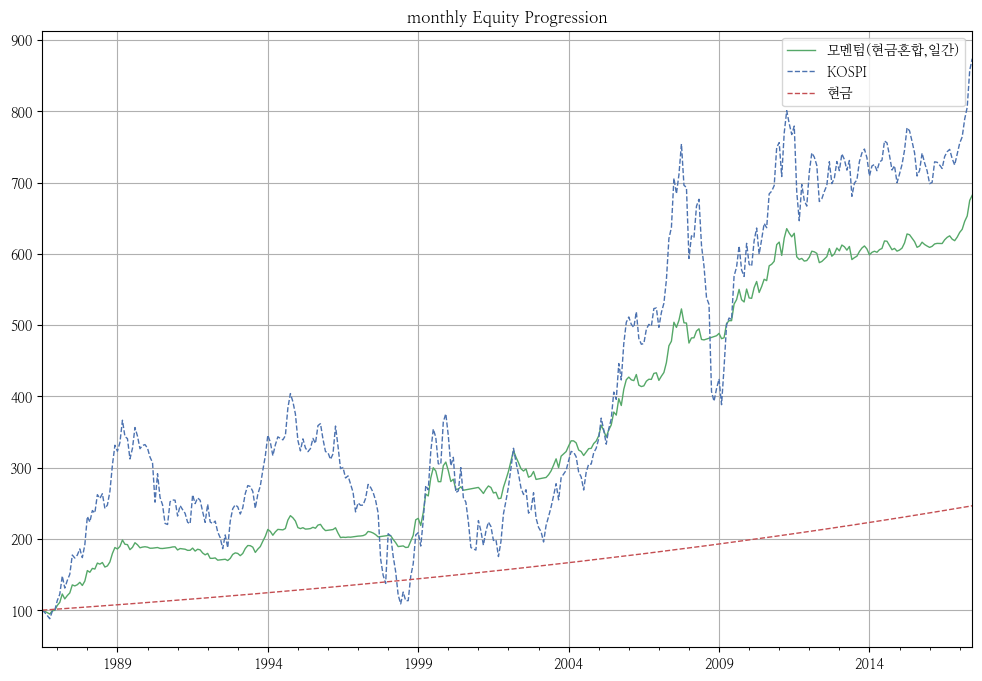

In [51]:
r_kospi1.set_date_range(start수익곡선모멘텀, e)
r_현금1.set_date_range(start수익곡선모멘텀, e)

ax1 = r_daily_현금혼합.plot(freq='M', color='g', figsize=(12,8));
r_kospi1.plot(ax=ax1, freq='M', ls='--', color='b', figsize=(12, 8));
r_현금1.plot(ax=ax1, freq='M', ls='--', color='r', figsize=(12, 8));

In [52]:
r_daily_현금혼합.set_date_range(start평균모멘텀스코어)
r_daily_현금혼합.prices

,"모멘텀(현금혼합,일간)"
1986-01-31,100.000
1986-02-01,100.609
1986-02-03,100.910
1986-02-04,100.723
1986-02-05,100.411
...,...
2017-06-26,901.322
2017-06-27,901.984
2017-06-28,900.234
2017-06-29,902.760


## 수익곡선모멘텀 WeighAMS

In [53]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMS(bt.Algo):
    def __init__(self, lags, months, cash):
        super(WeighAMS, self).__init__()
        self.lags = lags
        self.months = months
        self.cash = cash

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lags)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lags) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        selected.remove(self.cash)
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False
        print(f"\nprc : {target.now} {t0} ~ {start}")#\n{prc}")

        weights = pd.Series(self.AMS(prc), index=selected)
        weights[self.cash] = 1 - weights.sum()
        # print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights

        return True

In [54]:
class WeighAverageMomentumScoreExcludeCash(bt.Algo):
    """ 자산에 현금을 포함한 평균모멘텀스코어 전략
    
    매월초에 리밸런싱하고 전달 종가 기준으로 lookback 만큼의 월의 평균모멘텀스코어를 계산하여
    비중을 계산한다.
    """
    def __init__(self, lookback=12, cash='현금'):
        super(WeighAverageMomentumScoreExcludeCash, self).__init__()
        self.lookback = lookback
        self.cash     = cash

    def average_momentum_score(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        if len(prc) != (self.lookback+1):
            raise ValueError(f"must be resample('M').last(), {prc}")
        average_momentum_score = pd.Series(dtype='float64')
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        selected.remove(self.cash)

        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        # prc = target.universe[selected].loc[start:t0]
        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False

        weights = pd.Series(self.average_momentum_score(prc), index=selected)
        weights[self.cash] = 1 - weights.sum()

        target.temp['weights'] = weights

        return True

In [55]:
수익곡선모멘텀6 = bt.Strategy('수익곡선모멘텀6',
    [
        bt.algos.RunMonthly(run_on_first_date=True,
                            run_on_end_of_period=True, # 월말
                            run_on_last_date=False),
        bt.algos.SelectAll(),
        WeighAMS(lags=0, months = 6, cash='현금'), # lags=0이면 위와 같다.
        PrintTempWeights(),
        bt.algos.Rebalance()
    ]
)

In [56]:
r_daily_현금혼합.prices

,"모멘텀(현금혼합,일간)"
1986-01-31,100.000
1986-02-01,100.609
1986-02-03,100.910
1986-02-04,100.723
1986-02-05,100.411
...,...
2017-06-26,901.322
2017-06-27,901.984
2017-06-28,900.234
2017-06-29,902.760


In [57]:
data_daily_현금혼합 = pd.DataFrame()
data_daily_현금혼합['수익곡선모멘텀6'] = r_daily_현금혼합.prices
# %%
dd = pd.DataFrame()
dd.index = pd.date_range(start평균모멘텀스코어, e, freq='D')
denominator = len(pd.date_range(start평균모멘텀스코어, e, freq='D'))/len(pd.date_range(start평균모멘텀스코어, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily_현금혼합 = pd.merge(data_daily_현금혼합, dd, left_index=True, right_index=True, how='left')

In [58]:
data_daily_현금혼합

,수익곡선모멘텀6,현금
1986-01-31,100.000,1.000
1986-02-01,100.609,1.000
1986-02-03,100.910,1.000
1986-02-04,100.723,1.000
1986-02-05,100.411,1.000
...,...,...
2017-06-26,901.322,2.499
2017-06-27,901.984,2.499
2017-06-28,900.234,2.499
2017-06-29,902.760,2.500


In [59]:
bt_수익곡선모멘텀6 = bt.Backtest(수익곡선모멘텀6, data_daily_현금혼합, initial_capital=100000000)
r_수익곡선모멘텀6 = bt.run(bt_수익곡선모멘텀6)


prc : 1986-07-31 00:00:00 1986-07 ~ 1986-01
1986-07-31 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:1.000 현금:0.000 

prc : 1986-08-30 00:00:00 1986-08 ~ 1986-02
1986-08-30 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.833 현금:0.167 

prc : 1986-09-30 00:00:00 1986-09 ~ 1986-03
1986-09-30 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.667 현금:0.333 

prc : 1986-10-31 00:00:00 1986-10 ~ 1986-04
1986-10-31 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.500 현금:0.500 

prc : 1986-11-29 00:00:00 1986-11 ~ 1986-05
1986-11-29 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.833 현금:0.167 

prc : 1986-12-26 00:00:00 1986-12 ~ 1986-06
1986-12-26 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.833 현금:0.167 

prc : 1987-01-31 00:00:00 1987-01 ~ 1986-07
1987-01-31 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:1.000 현금:0.000 

prc : 1987-02-28 00:00:00 1987-02 ~ 1986-08
1987-02-28 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:1.000 현금:0.000 

prc : 1987-03-31 00:00:00 1987-03 ~ 1986-09
1987-03-31 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:1.000 현금:0.000 

prc : 1987-04-30 00:00:00 1987-04 ~ 1986-10
1987-04-30 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.833 현금:0.167 

prc : 198

In [60]:
r_수익곡선모멘텀6.set_date_range(start수익곡선모멘텀,e)
r_수익곡선모멘텀6.display()

Stat                 수익곡선모멘텀6
-------------------  -----------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         577.87%
Daily Sharpe         0.90
Daily Sortino        1.43
CAGR                 6.39%
Max Drawdown         -13.74%
Calmar Ratio         0.46

MTD                  1.07%
3m                   5.56%
6m                   9.28%
YTD                  9.28%
1Y                   10.45%
3Y (ann.)            4.61%
5Y (ann.)            2.88%
10Y (ann.)           3.40%
Since Incep. (ann.)  6.39%

Daily Sharpe         0.90
Daily Sortino        1.43
Daily Mean (ann.)    6.11%
Daily Vol (ann.)     6.79%
Daily Skew           0.07
Daily Kurt           10.78
Best Day             3.82%
Worst Day            -3.85%

Monthly Sharpe       0.86
Monthly Sortino      2.07
Monthly Mean (ann.)  6.48%
Monthly Vol (ann.)   7.51%
Monthly Skew         1.53
Monthly Kurt         5.42
Best Month           10.91%
Worst Month          -5.62%



## 그림 2.38 (일간)

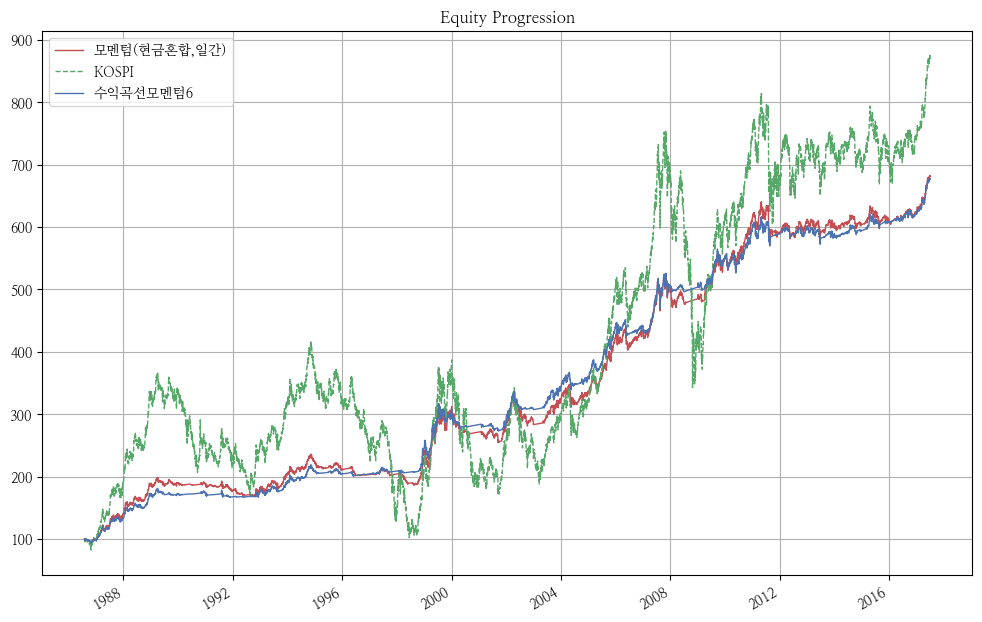

In [61]:
r_daily_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_kospi1.set_date_range(start수익곡선모멘텀,e)
r_수익곡선모멘텀6.set_date_range(start수익곡선모멘텀,e)

ax1 = r_daily_현금혼합.plot(color='r', figsize=(12,8));
r_kospi1.plot(ax=ax1, ls='--', color='g', figsize=(12, 8));
r_수익곡선모멘텀6.plot(ax=ax1, ls='-', color='b', figsize=(12, 8));
#----
# r_ms0.plot(ax=ax1, ls='--', color='gray', figsize=(12, 8));

# bt 적 방법으로 구현 (일일 데이타)
- 월말 리밸런싱(run_end_of_period=True) 계산은 하루전(lag=pd.DateOffset(days=1))

- 월초 리밸런싱, 전달 종가기준 계산

## 평균모멘텀스코어 class WeighAverageMomentumScore(bt.Algo):

In [62]:
class WeighAverageMomentumScore(bt.Algo):
    def __init__(self, months=12, lag=pd.DateOffset(days=0), cash='현금', cash_weigh=0.0, 현금자산제외=True):
        super(WeighAverageMomentumScore, self).__init__()
        self.lookback = months
        self.lag = lag
        self.cash = cash
        self.cash_weigh = cash_weigh
        self.현금자산제외 = 현금자산제외

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        # print("===", selected)
        if self.현금자산제외: # 현금자산빼고 모멘텀 비중나누고 나머지는 현금으로 , 아니면 현금도 하나의 자산으로
            selected.remove(self.cash)

        t0 = target.now - self.lag

        if target.universe[selected].index[0] > (t0 - pd.DateOffset(months=self.lookback)): # !!!
            return False

        momentums_score = 0
        for lookback in range(1, self.lookback+1):
            start = t0 - pd.DateOffset(months=lookback)
            prc = target.universe[selected].loc[start:t0]
            momentum_score = np.where(prc.calc_total_return() > 0, 1, 0)
            momentums_score += momentum_score

        average_momentum_score = momentums_score / self.lookback
#         print(average_momentum_score)

        average_momentum_score *= (1 - self.cash_weigh)
        
        # XXX systrader79/backtesting/ebook/dynamic/10.mxied_korea_us.py 수정필요
        if self.현금자산제외: ## XXX 이 로직이 맞는지 모르겠음
            weights = average_momentum_score/len(selected) 
            weights = pd.Series(weights, index=selected)
            weights[self.cash] = 1-weights.sum()
        else:
            weights = average_momentum_score/average_momentum_score.sum()
            weights = pd.Series(weights, index=selected)


        target.temp['weights'] = weights

        return True

In [63]:
def average_momentum_score_mixed_cash(name, data, months=12, lag=pd.DateOffset(days=0), cash='현금', 현금자산제외=False):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=True, #월말
                                run_on_last_date=False),
            bt.algos.SelectAll(),
            WeighAverageMomentumScore(months=months, lag=lag, cash=cash, 현금자산제외=현금자산제외),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)

In [64]:
data_daily

,KOSPI,현금
Date,,
1985-01-30,137.970,1.000
1985-01-31,138.900,1.000
1985-02-01,138.840,1.000
1985-02-02,138.480,1.000
1985-02-04,136.870,1.000
...,...,...
2017-06-26,2388.660,2.574
2017-06-27,2391.950,2.574
2017-06-28,2382.560,2.574


In [65]:
# 월말, 계산은 하루전
bt_ams_mixed_cash = average_momentum_score_mixed_cash("평균모멘텀스코어(현금혼합)", data_daily, 12, pd.DateOffset(days=1), '현금')
r_ams_mixed_cash = bt.run(bt_ams_mixed_cash)

1986-01-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1986-02-28 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-03-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-04-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-05-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-06-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-07-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-08-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1986-09-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.455 현금:0.545 
1986-10-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.400 현금:0.600 
1986-11-29 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1986-12-26 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1987-01-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1987-02-28 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1987-03-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1987-04-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1987-05-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1987-06-30 00:00:00 평균모멘텀스코어(현금

In [66]:
r_ams_mixed_cash.set_date_range(start수익곡선모멘텀, e)
r_ams_mixed_cash.display()

Stat                 평균모멘텀스코어(현금혼합)
-------------------  ----------------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         575.81%
Daily Sharpe         0.77
Daily Sortino        1.23
CAGR                 6.38%
Max Drawdown         -21.28%
Calmar Ratio         0.30

MTD                  1.07%
3m                   5.56%
6m                   9.43%
YTD                  9.43%
1Y                   10.80%
3Y (ann.)            3.65%
5Y (ann.)            2.81%
10Y (ann.)           3.62%
Since Incep. (ann.)  6.38%

Daily Sharpe         0.77
Daily Sortino        1.23
Daily Mean (ann.)    6.19%
Daily Vol (ann.)     8.08%
Daily Skew           -0.10
Daily Kurt           6.92
Best Day             3.82%
Worst Day            -4.07%

Monthly Sharpe       0.73
Monthly Sortino      1.60
Monthly Mean (ann.)  6.59%
Monthly Vol (ann.)   8.98%
Monthly Skew         0.93
Monthly Kurt         2.60
Best Month           10.91%
Worst Month 

In [67]:
bt_kospi1 = long_only_ew(data_daily, ['KOSPI'], 'KOSPI')
bt_현금1 = long_only_ew(data_daily, ['현금'], '현금')

In [68]:
r_kospi1 = bt.run(bt_kospi1)
r_현금1 = bt.run(bt_현금1)

1985-01-30 00:00:00
1985-01-30 00:00:00


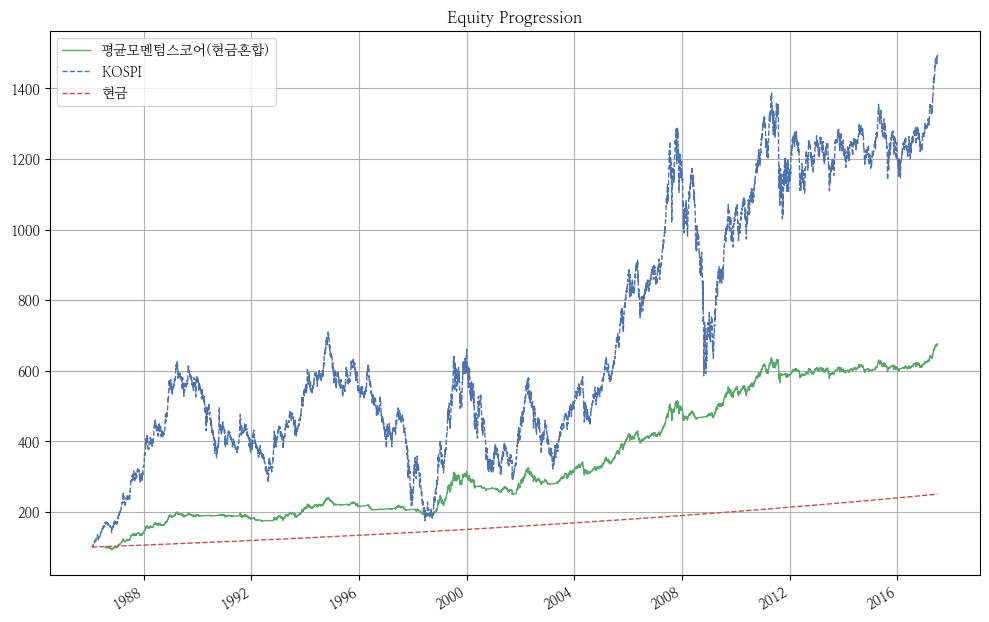

In [69]:
r_kospi1.set_date_range(start평균모멘텀스코어, e)
r_현금1.set_date_range(start평균모멘텀스코어, e)

# %%
ax1 = r_ams_mixed_cash.plot(color='g', figsize=(12,8));
r_kospi1.plot(ax=ax1, ls='--', color='b', figsize=(12, 8));
r_현금1.plot(ax=ax1, ls='--', color='r', figsize=(12, 8));

## 수익곡선모멘텀

In [70]:
r_ams_mixed_cash.set_date_range(start평균모멘텀스코어)
r_ams_mixed_cash.prices

,평균모멘텀스코어(현금혼합)
1986-01-31,100.000
1986-02-01,100.609
1986-02-03,100.910
1986-02-04,100.723
1986-02-05,100.411
...,...
2017-06-26,892.959
2017-06-27,893.614
2017-06-28,891.881
2017-06-29,894.383


## 데이타 생성

In [71]:
data_daily2 = pd.DataFrame()
data_daily2['수익곡선모멘텀6'] = r_ams_mixed_cash.prices
# %%
dd = pd.DataFrame()
dd.index = pd.date_range(start평균모멘텀스코어, e, freq='D')
denominator = len(pd.date_range(start평균모멘텀스코어, e, freq='D'))/len(pd.date_range(start평균모멘텀스코어, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily2 = pd.merge(data_daily2, dd, left_index=True, right_index=True, how='left')

In [72]:
data_daily2

,수익곡선모멘텀6,현금
1986-01-31,100.000,1.000
1986-02-01,100.609,1.000
1986-02-03,100.910,1.000
1986-02-04,100.723,1.000
1986-02-05,100.411,1.000
...,...,...
2017-06-26,892.959,2.499
2017-06-27,893.614,2.499
2017-06-28,891.881,2.499
2017-06-29,894.383,2.500


In [73]:
bt_returns_curve_mom = average_momentum_score_mixed_cash(
                       "평균모멘텀스코어(현금혼합)+수익곡선모멘텀", 
                       data_daily2, 
                       6, 
                       pd.DateOffset(days=1), 
                       '현금', 
                       현금자산제외=True)
r_returns_curve_mom = bt.run(bt_returns_curve_mom)

1986-07-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1986-08-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1986-09-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.667 현금:0.333 
1986-10-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.500 현금:0.500 
1986-11-29 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1986-12-26 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-01-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-02-28 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-03-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-04-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1987-05-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1987-06-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-07-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-08-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1987-09-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모

In [74]:
r_returns_curve_mom.set_date_range(start수익곡선모멘텀,e)
r_returns_curve_mom.display()

Stat                 평균모멘텀스코어(현금혼합)+수익곡선모멘텀
-------------------  -------------------------------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         560.43%
Daily Sharpe         0.88
Daily Sortino        1.40
CAGR                 6.30%
Max Drawdown         -12.88%
Calmar Ratio         0.49

MTD                  1.07%
3m                   5.56%
6m                   9.28%
YTD                  9.28%
1Y                   10.30%
3Y (ann.)            4.23%
5Y (ann.)            2.86%
10Y (ann.)           3.28%
Since Incep. (ann.)  6.30%

Daily Sharpe         0.88
Daily Sortino        1.40
Daily Mean (ann.)    6.03%
Daily Vol (ann.)     6.81%
Daily Skew           0.03
Daily Kurt           10.59
Best Day             3.82%
Worst Day            -3.85%

Monthly Sharpe       0.85
Monthly Sortino      1.99
Monthly Mean (ann.)  6.40%
Monthly Vol (ann.)   7.53%
Monthly Skew         1.41
Monthly Kurt         4.96
Best Month       

In [75]:
r_returns_curve_mom.prices.resample('M').last().to_drawdown_series().describe()

,평균모멘텀스코어(현금혼합)+수익곡선모멘텀
count,372.000
mean,-0.034
std,0.026
min,-0.100
25%,-0.052
50%,-0.032
75%,-0.009
max,0.000


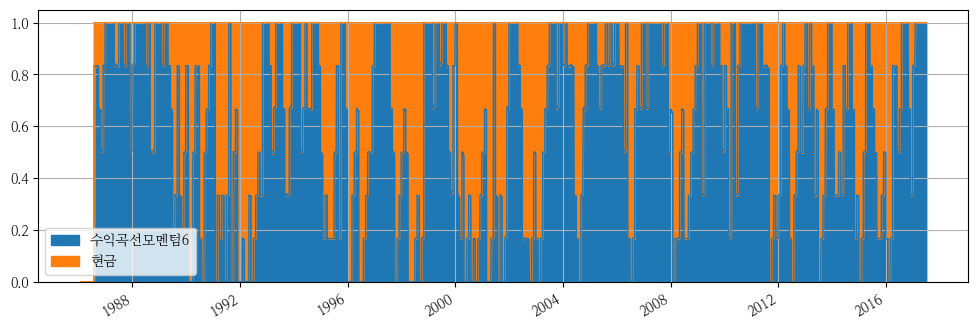

In [76]:
r_returns_curve_mom.get_security_weights().plot.area(figsize=(12,4));

In [77]:
r_returns_curve_mom.prices

,평균모멘텀스코어(현금혼합)+수익곡선모멘텀
1986-07-31,100.000
1986-08-01,99.063
1986-08-02,99.644
1986-08-04,99.583
1986-08-05,99.209
...,...
2017-06-26,659.886
2017-06-27,660.370
2017-06-28,659.089
2017-06-29,660.939


                        CAGR
평균모멘텀스코어(현금혼합)+수익곡선모멘텀 6.296
                           MDD
평균모멘텀스코어(현금혼합)+수익곡선모멘텀 -12.881


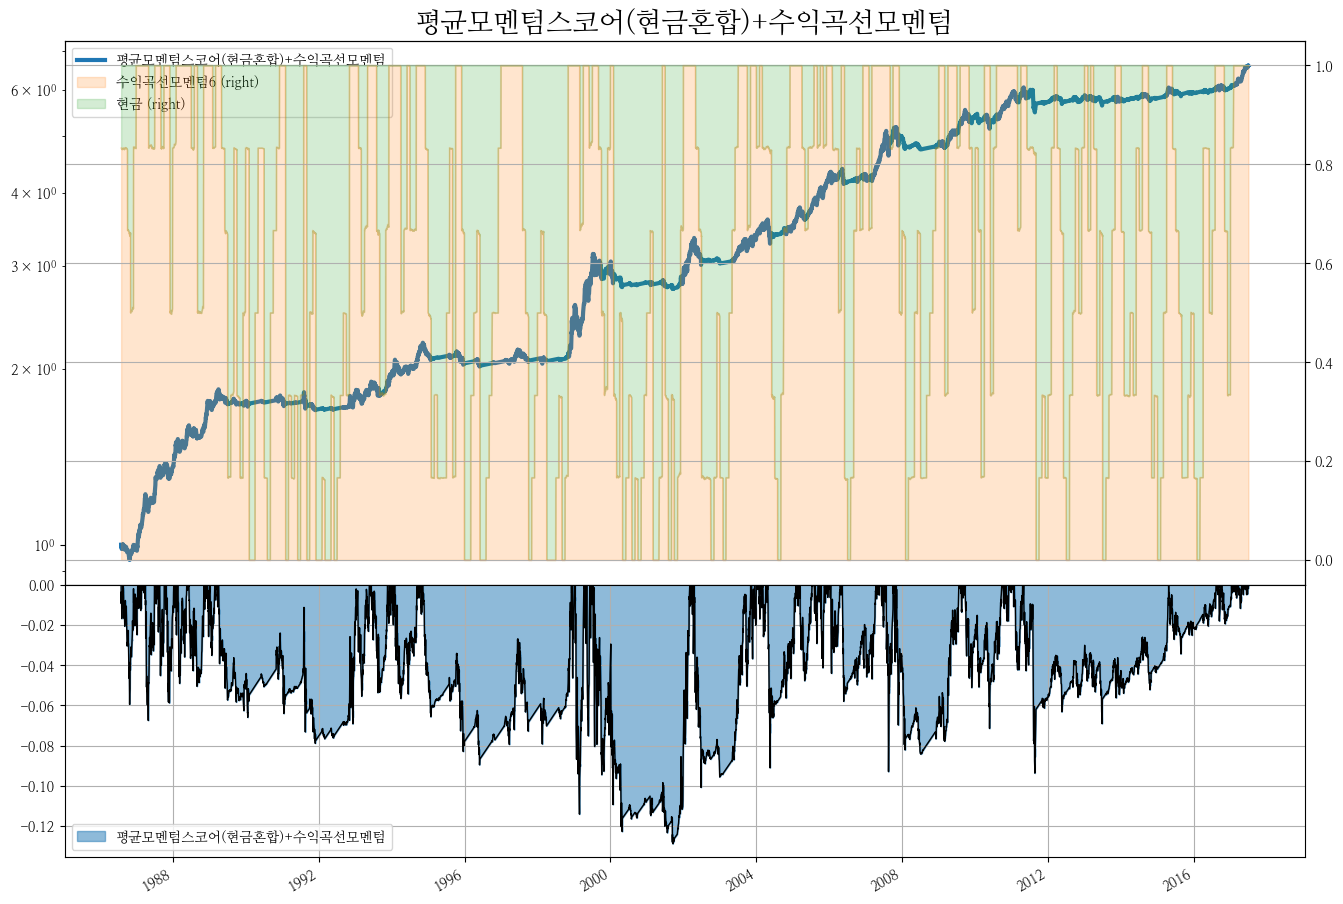

In [78]:
plot_assets(r_returns_curve_mom, start수익곡선모멘텀, e, "평균모멘텀스코어(현금혼합)+수익곡선모멘텀")

## 그림 2.38 (일간, bt적 알고)

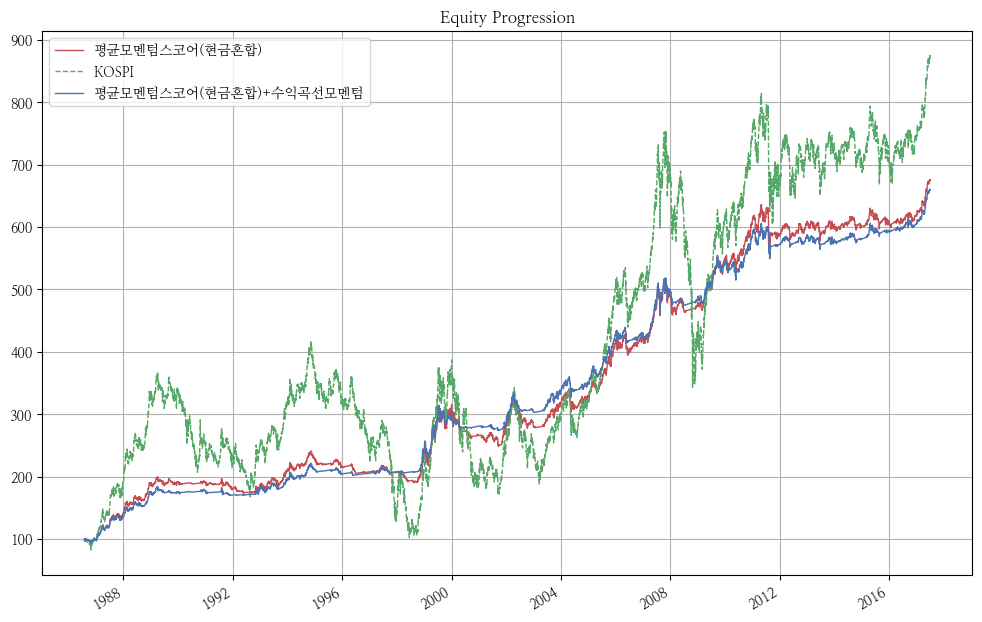

In [79]:
r_ams_mixed_cash.set_date_range(start수익곡선모멘텀)
r_kospi1.set_date_range(start수익곡선모멘텀)
r_returns_curve_mom.set_date_range(start수익곡선모멘텀)
ax1 = r_ams_mixed_cash.plot(color='r', figsize=(12,8));
r_kospi1.plot(ax=ax1, ls='--', color='g', figsize=(12, 8));
r_returns_curve_mom.plot(ax=ax1, ls='-', color='b', figsize=(12, 8));
#----
# r_ms0.plot(ax=ax1, ls='--', color='gray', figsize=(12, 8));

## 비교
- 월별 비중 데이터프레임
  - CAGR                 6.43%/Max Drawdown         -19.12%
  - CAGR                 6.44%/Max Drawdown         -10.19% (수익곡선모멘텀6)
  
- 일일데이터 비중 클래스
  - CAGR                 6.41%/Max Drawdown         -21.13%
  - CAGR                 6.39%/ Max Drawdown         -13.74% (수익곡선모멘텀6)

- bt적 방법 (월말 리밸런싱, 1일전기준 계산)
  - CAGR                 6.38%/Max Drawdown         -21.28%
  - CAGR                 6.30%/Max Drawdown         -12.88% (수익곡선모멘텀6)

In [80]:
r_daily_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_수익곡선모멘텀6.set_date_range(start수익곡선모멘텀,e)
r_ams_mixed_cash.set_date_range(start수익곡선모멘텀,e)
r_returns_curve_mom.set_date_range(start수익곡선모멘텀,e)

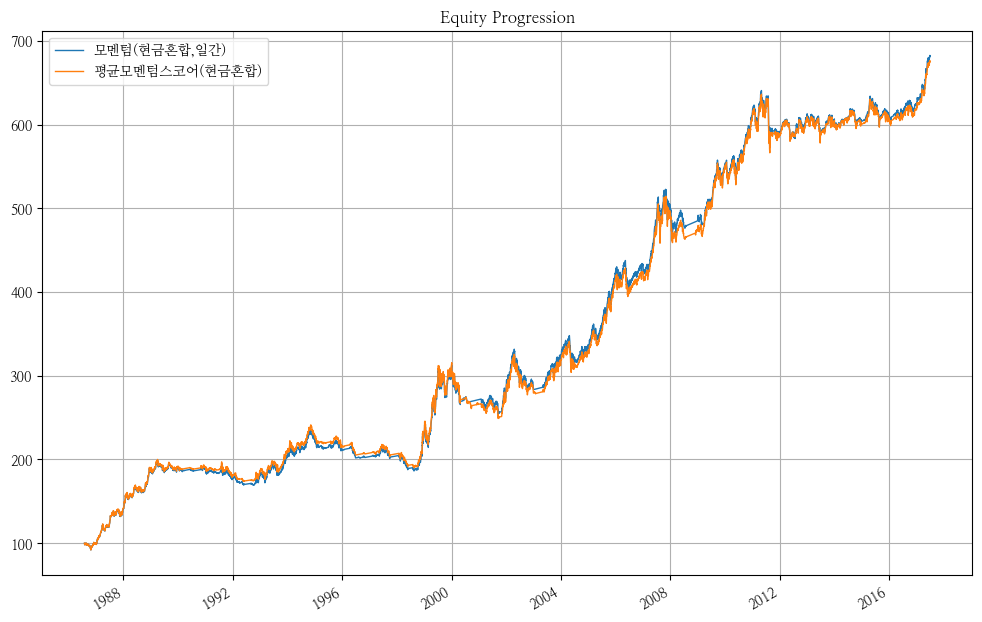

In [81]:
ax1 = r_daily_현금혼합.plot(figsize=(12,8));
# r_수익고선모멘텀6.plot(ax=ax1,figsize=(12,8));
#--
r_ams_mixed_cash.plot(ax=ax1,figsize=(12,8));
# r_returns_curve_mom.plot(ax=ax1,figsize=(12,8));

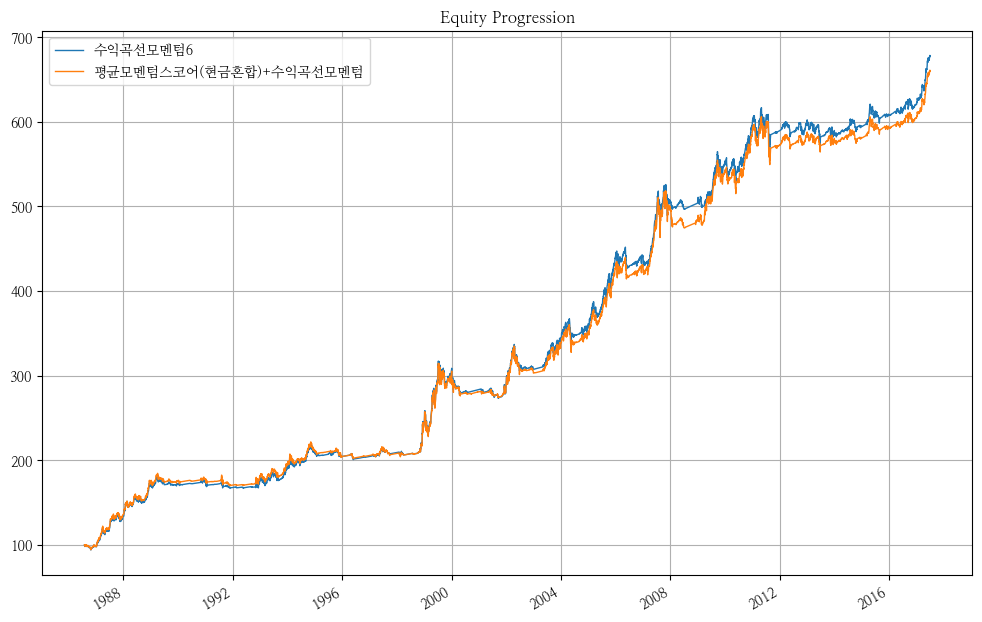

In [82]:
# ax1 = r_daily.plot(figsize=(12,8));
ax1 = r_수익곡선모멘텀6.plot(figsize=(12,8));
#--
# r_ams_mixed_cash.plot(ax=ax1,figsize=(12,8));
r_returns_curve_mom.plot(ax=ax1,figsize=(12,8));

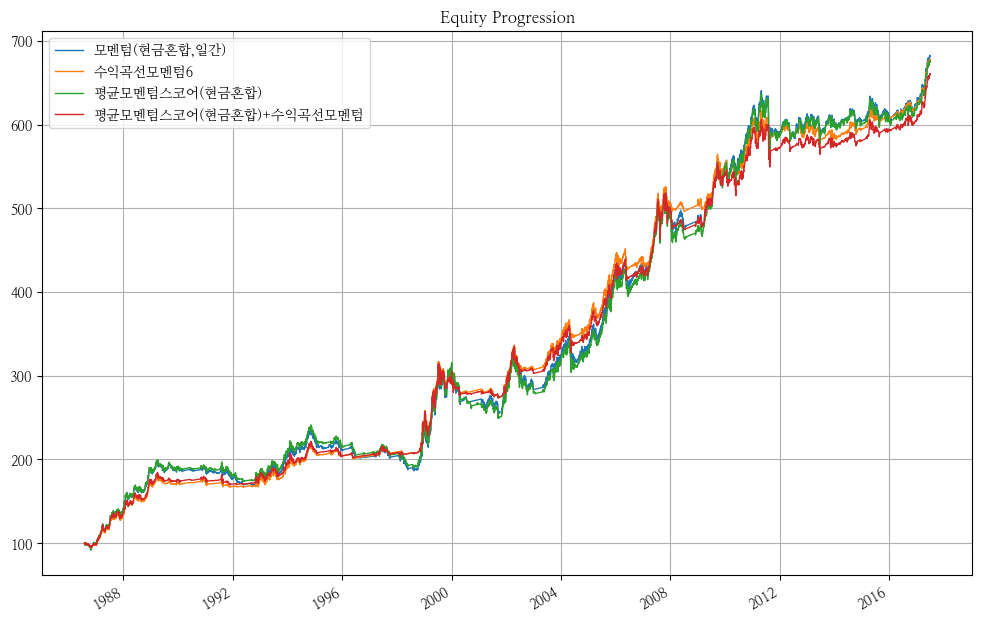

In [84]:
ax1 = r_daily_현금혼합.plot(figsize=(12,8));
r_수익곡선모멘텀6.plot(ax=ax1,figsize=(12,8));
#--
r_ams_mixed_cash.plot(ax=ax1,figsize=(12,8));
r_returns_curve_mom.plot(ax=ax1,figsize=(12,8));